In [1]:
using Plots
using Revise
# include project utilities
includet("choques_utils.jl")
# complementary_utils.jl is included so its TVD routines are available if you want to call them.

includet("complementary_utils.jl")



### Log:

The parabolic part is working, the weno seems to be OK, but the solution oscilates a lot. 


In [69]:
# Grid setup
    n = 5
    L = 1
    dx = L / (n-1)
    x0 = 0.0
    x_p = ((0:n-1) .* dx) .+ x0
    x_centers = ((0:n-2) .* dx) .+ dx/2 .+ x0
    x_centers_ext = vcat(-5dx/2,-3dx/2, -dx/2, x_centers, L+dx/2, L+3dx/2, L+5dx/2);
    


10-element Vector{Float64}:
 -0.625
 -0.375
 -0.125
  0.125
  0.375
  0.625
  0.875
  1.125
  1.375
  1.625

In [70]:
# Parameters for evolution
η = 0.005  # viscosity parameter
dt = 0.5*min(dx * dx / η, dx)  # CFL-based timestep
#dt = 0.5*dx
    
# Initial condition: smooth bump
#u0 = @. exp(-(x_centers - L/2)^2 * 4)
    

# As u we use cos(2π * x/2) as \bar(u) we get  2(sin(2π * (x+dx/2)/2) - sin(2π * (x-dx/2)/2)/dx

u_bar_int = 2/dx*(sin.(2π * x_centers/2) - sin.((2π * x_centers .-dx)/2))
    
    

u0 = vcat(u_bar_int[1],u_bar_int[1],u_bar_int[1], u_bar_int, u_bar_int[end],u_bar_int[end], u_bar_int[end]); # Ghost cells with constant values

#plot(x_centers, u0[3:end-2])
#plot!(x_centers, cos.(x_centers./2)) #This is correct
#plot(x_centers_ext, u0) # This is correct, but the centers at the boundaries are a bit off. 
u = copy(u0)
du = zeros(length(u));

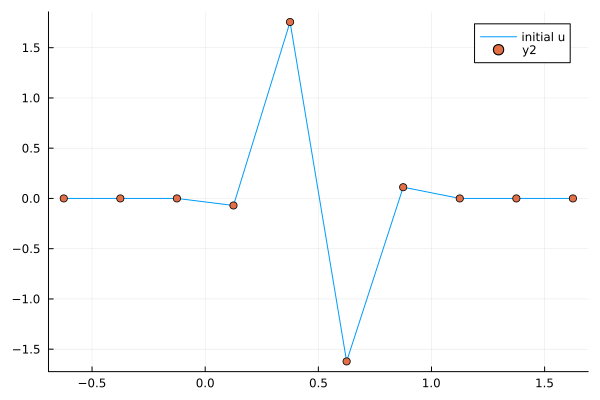

In [71]:
t = 0
plot(x_centers_ext, burgers_rhs(u0, t, (dx, η, du)), label="initial u")
scatter!((x_centers_ext, burgers_rhs(u0, t, (dx, η, du))))

In [72]:

    # Time evolution with TVD3
    t = 0.0
    t_final = 40.0
    params = (dx, η, du)
    nsteps = round(Int, t_final/dt)
    
    # Basic tests before evolution
    @show length(u) == n + 5 # Correct size with ghost cells
    @show maximum(abs.(u .- u0)) < 1e-14
    
    # Evolve (f,y0,t0,h,pf)
    max_u = zeros(nsteps)
    int_u = zeros(nsteps)
    max_u[1] = maximum(u[4:n+2])
    int_u[1] = sum(u[4:n+2])*dx
    for i in 2:nsteps
        TVD3_Step!(burgers_rhs, u, t, dt, params)
        println("t = $t, max_u = $(maximum(u[4:n+2])), int_u = $(sum(u[4:n+2])*dx)")
        max_u[i] = maximum(u[4:n+2])
        int_u[i] = sum(u[4:n+2])*dx
        t += dt
    end
    
    # Basic sanity checks after evolution
    @show !any(isnan.(u[4:n+2]))  # No NaNs
    @show maximum(abs.(u[4:n+2])) ≤ maximum(abs.(u0[4:n+2])) * 1.1  # Max principle approximately
    @show isapprox(sum(u[4:n+2]) * dx, sum(u0[4:n+2]) * dx,  rtol=1e-3)  # Mass conservation


false

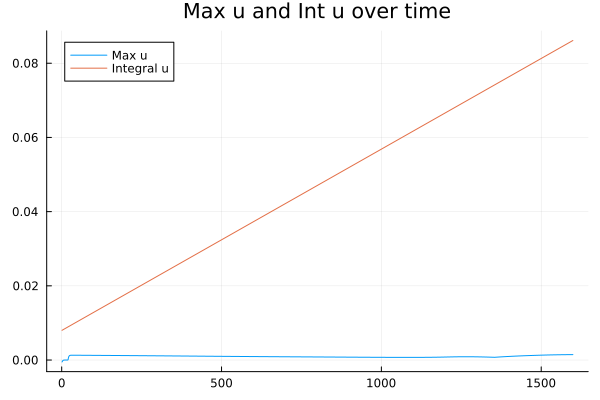

In [66]:
plot(max_u[2:end] .- max_u[1], label="Max u", #yscale=:log10, 
#ylim=(0.0, maximum(max_u[2:end] .- max_u[1])*1.1),
title="Max u and Int u over time")
plot!(int_u[2:end], label="Integral u")

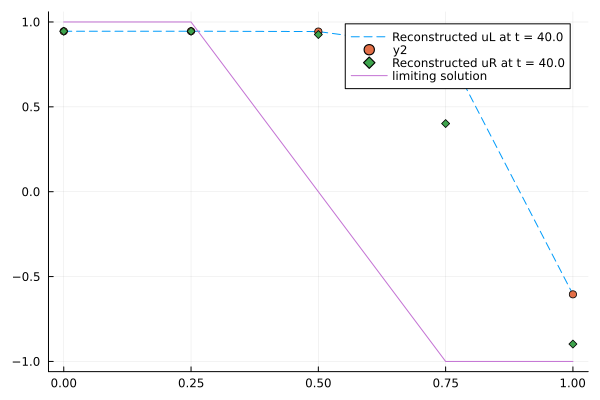

In [73]:
#plot(x_centers,u[4:end-3], label="u at t = $t_final")
uL, u_R, _, _ = WENOZ_FV_reconstruct_from_averages(u, dx)
plot(x_p,uL, label="Reconstructed uL at t = $t_final", linestyle=:dash)
scatter!(x_p,uL)
scatter!(x_p,u_R, label="Reconstructed uR at t = $t_final", marker=:diamond)
plot!(x_p, -tanh.((x_p .-L/2)/2/η), label="limiting solution")


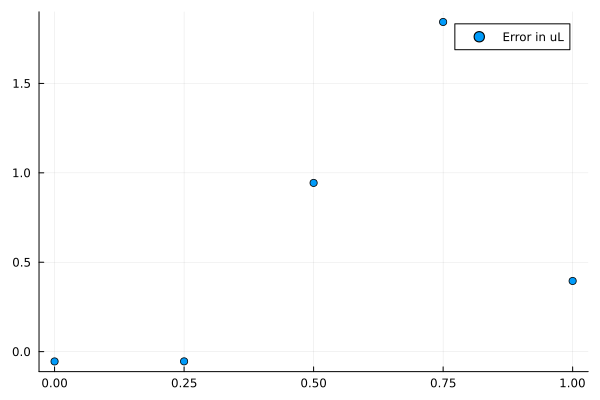

In [74]:
scatter(x_p,uL - -tanh.((x_p .-L/2)/2/η), label="Error in uL")